In [1]:
!pip install pmdarima

  Using cached pmdarima-2.0.2-cp38-cp38-win_amd64.whl (571 kB)


In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [2]:
df=pd.read_csv('bitcoin.csv',index_col='Date')  

df.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2010-07-18,0.0,0.1,0.1,0.1,75,USD
2010-07-19,0.1,0.1,0.1,0.1,574,USD
2010-07-20,0.1,0.1,0.1,0.1,262,USD
2010-07-21,0.1,0.1,0.1,0.1,575,USD
2010-07-22,0.1,0.1,0.1,0.1,2160,USD


In [3]:
df.index = pd.to_datetime(df.index) 
df.index

DatetimeIndex(['2010-07-18', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23', '2010-07-24', '2010-07-25',
               '2010-07-26', '2010-07-27',
               ...
               '2022-08-14', '2022-08-15', '2022-08-16', '2022-08-17',
               '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21',
               '2022-08-22', '2022-08-23'],
              dtype='datetime64[ns]', name='Date', length=4420, freq=None)

In [4]:
ts=df['Close'] 
ts.head() 

Date
2010-07-18    0.1
2010-07-19    0.1
2010-07-20    0.1
2010-07-21    0.1
2010-07-22    0.1
Name: Close, dtype: float64

Text(0, 0.5, 'Close Prices')

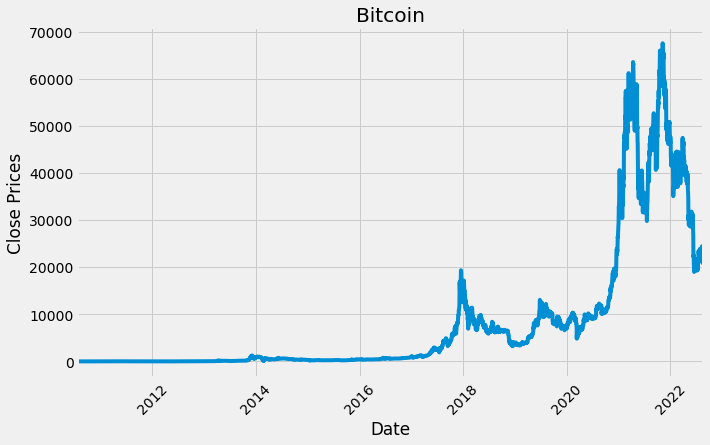

In [5]:
plt.rcParams['axes.unicode_minus'] = False  
ts.plot()         
plt.title("Bitcoin") 
plt.xticks(rotation=45)    
plt.xlabel('Date')   
plt.ylabel('Close Prices')

<AxesSubplot:ylabel='Density'>

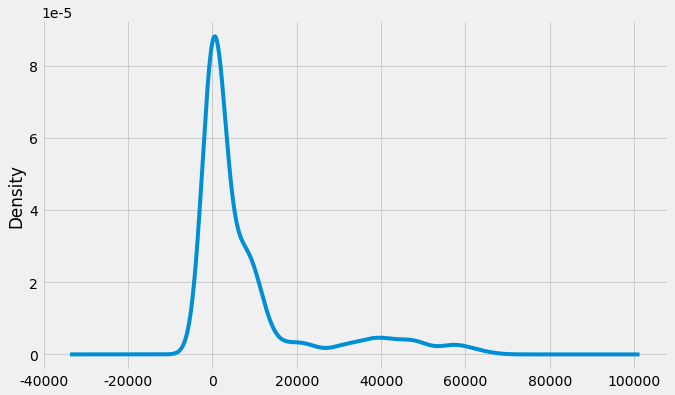

In [6]:
#Distribution of the dataset
ts.plot(kind='kde')

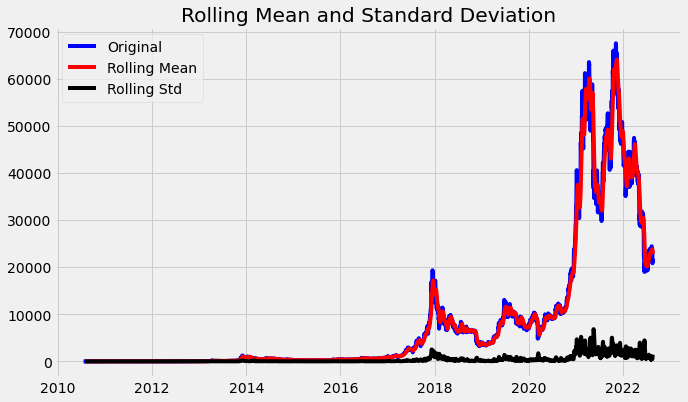

Results of dickey fuller test
Test Statistics                  -1.750985
p-value                           0.405053
No. of lags used                 31.000000
Number of observations used    4388.000000
critical value (1%)              -3.431841
critical value (5%)              -2.862199
critical value (10%)             -2.567121
dtype: float64


In [7]:
# Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(ts)

Through the above graph, we can see the varying mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the null hypothesis. Also, the test statistics is greater than the critical values. All these justification lead to the conclusion that the series is not stationary.

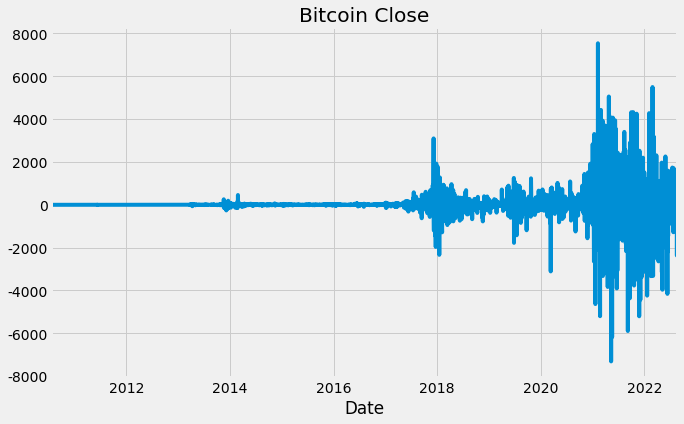

In [8]:
D_ts = ts.diff().dropna() 
D_ts.columns = [u'Difference in Close Prices']
D_ts.plot()  
plt.title("Bitcoin Close")  
plt.show() 

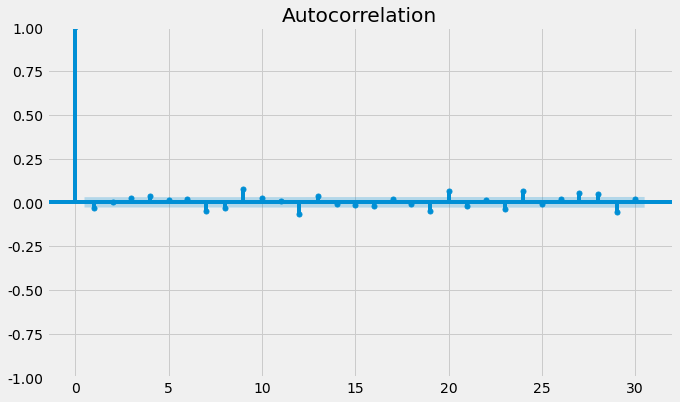

In [9]:
from statsmodels.graphics.tsaplots import plot_acf 
plot_acf(D_ts,use_vlines=True,lags=30)  
plt.show() 

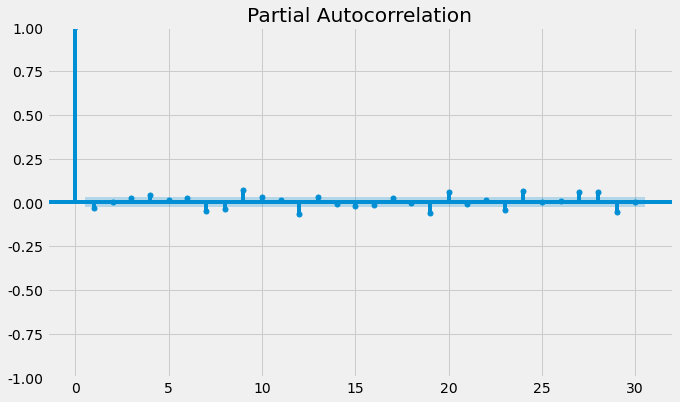

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf  
plot_pacf(D_ts,use_vlines=True,lags=30)  
plt.show()  

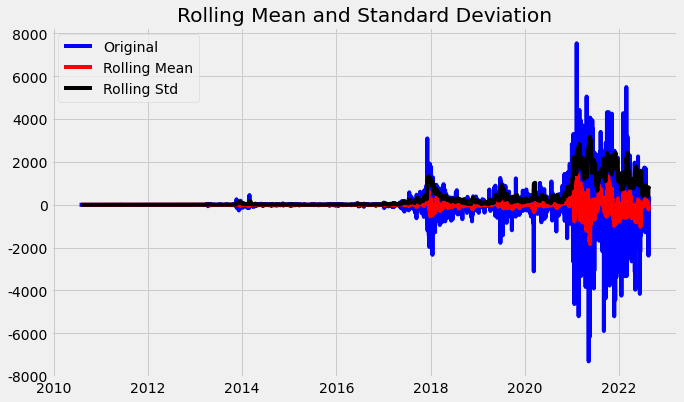

Results of dickey fuller test
Test Statistics               -1.075978e+01
p-value                        2.538192e-19
No. of lags used               3.100000e+01
Number of observations used    4.387000e+03
critical value (1%)           -3.431841e+00
critical value (5%)           -2.862199e+00
critical value (10%)          -2.567121e+00
dtype: float64


In [11]:
test_stationarity(D_ts)

We see that the p-value is less than 0.05 so we reject the null hypothesis. Also, the test statistics is less than the critical values. All these justification lead to the conclusion that the series now becomes stationary.

In [12]:
from statsmodels.tsa import stattools 
LjungBox=stattools.q_stat(stattools.acf(D_ts)[1:12],len(D_ts)) 
LjungBox[1][-1]

1.3808584572447371e-08

Since the p-value is less than 0.05 so we reject the null hypothesis. This is not a white noise series.

In [13]:
df_log = np.log(ts)

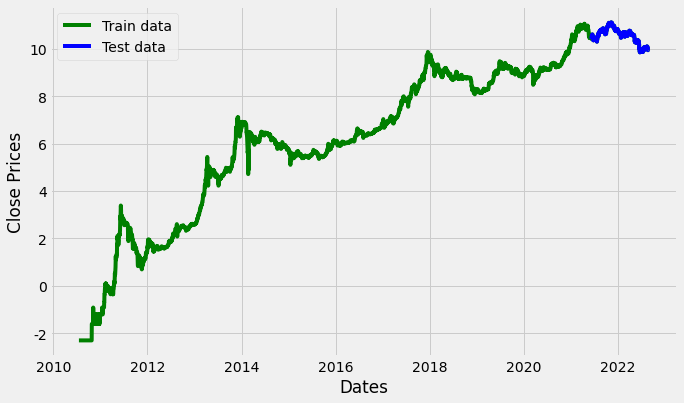

In [14]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10221.790, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10220.218, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10220.429, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10214.680, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10239.230, Time=1.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10327.325, Time=1.79 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10328.040, Time=0.72 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-10328.904, Time=1.81 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-10340.665, Time=3.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-10367.153, Time=3.59 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10357.807, Time=3.77 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-10366.264, Time=4.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-10365.191, Time=3.70 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-10360.523, Time=1.64 sec

Best

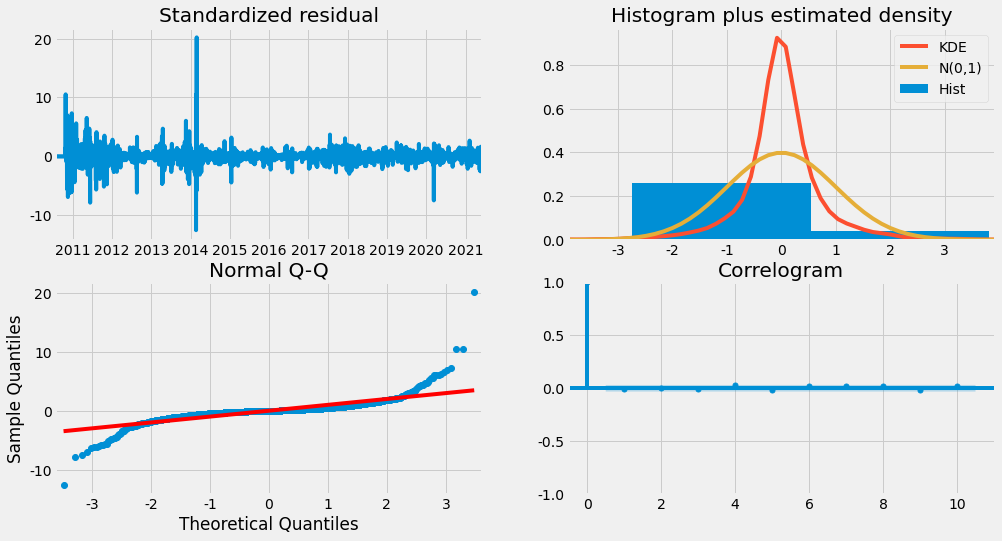

In [15]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

interpret:

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. 

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. 

Overall, it seems to be a good fit. then we start forecasting the stock prices.

In [16]:
# Modeling
# Build Model
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train_data, order=(3,1,2))
fitted = model.fit()

print(fitted.summary())

C:\Users\86173\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\86173\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\86173\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3975
Model:                 ARIMA(3, 1, 2)   Log Likelihood                5186.261
Date:                Thu, 01 Dec 2022   AIC                         -10360.523
Time:                        21:12:23   BIC                         -10322.798
Sample:                    07-21-2010   HQIC                        -10347.146
                         - 06-07-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8664      0.041     21.328      0.000       0.787       0.946
ar.L2         -0.6020      0.033    -18.355      0.000      -0.666      -0.538
ar.L3          0.1367      0.010     13.042      0.0

C:\Users\86173\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
test_data.shape

(442,)

In [21]:
# Forecast
n_periods = 24
fc, confint = fitted.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

ValueError: too many values to unpack (expected 2)

In [20]:
print(fitted.forecast(442, alpha=0.05))

2021-06-08    10.418320
2021-06-09    10.421512
2021-06-10    10.417450
2021-06-11    10.411557
2021-06-12    10.409333
                ...    
2022-08-19    10.411494
2022-08-20    10.411494
2022-08-21    10.411494
2022-08-22    10.411494
2022-08-23    10.411494
Freq: D, Name: predicted_mean, Length: 442, dtype: float64


In [23]:
fitted.plot_predict(dynamic=False)
plt.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'